Lets see if we can train to memorize one image?

In [37]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [38]:
f_img = '/Users/kuba/Documents/data/Raw/Face-Detection-Dataset/images/train/0a0d7a87378422e3.jpg'
f_label = '/Users/kuba/Documents/data/Raw/Face-Detection-Dataset/labels/train/0a0d7a87378422e3.txt'

In [39]:
image = Image.open(f_img)

# normalizes 0 to 1
transform = transforms.ToTensor()
img_tensor = transform(image) 

# Load label
with open(f_label, 'r') as f:
    label = f.readline().strip()  # Read first line
    bbox = torch.tensor([float(x) for x in label.split()])

print("Image tensor shape:", img_tensor.shape)
print("Label tensor:", bbox)

Image tensor shape: torch.Size([3, 1024, 683])
Label tensor: tensor([0.0000, 0.5076, 0.3823, 0.5736, 0.5206])


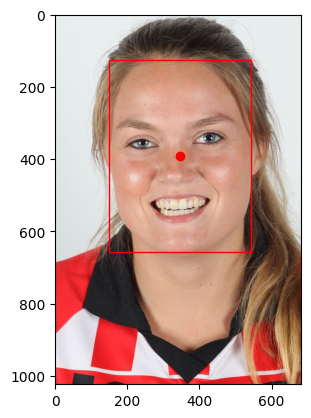

In [40]:
# Convert tensor to numpy for visualization
img_np = img_tensor.permute(1, 2, 0).numpy()

# Create plot
fig, ax = plt.subplots()
ax.imshow(img_np)

# Get image dimensions
H, W = img_np.shape[:2]

# Convert normalized bbox to pixel coordinates
x_center = bbox[1] * W
y_center = bbox[2] * H
width = bbox[3] * W
height = bbox[4] * H

# Plot center point
plt.plot(x_center, y_center, 'ro')

# Plot bbox
rect = plt.Rectangle((x_center - width/2, y_center - height/2),width, height,fill=False,color='red')
ax.add_patch(rect)

plt.show()

In [41]:
# class SimpleBoxNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 16, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(16, 32, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(32, 64, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#         )
#         self.regression = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(64 * (image.size[1]//8) * (image.size[0]//8), 128),
#             nn.ReLU(),
#             nn.Linear(128, 5)  # 5 values for YOLO format
#         )

#     def forward(self, x):
#         x = self.features(x)
#         return self.regression(x)
class SimpleBoxNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Calculate the flattened size
        with torch.no_grad():
            # Get input image size
            test_tensor = torch.zeros(1, 3, image.size[1], image.size[0])
            test_out = self.conv(test_tensor)
            flat_size = test_out.flatten().shape[0]
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 5)  # 5 values for YOLO format
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)


In [42]:

# Load data
image = Image.open(f_img)
transform = transforms.ToTensor()
img_tensor = transform(image).unsqueeze(0)  # Add batch dimension

with open(f_label, 'r') as f:
    label = f.readline().strip()
    bbox = torch.tensor([float(x) for x in label.split()]).unsqueeze(0)

# Setup model and training
model = SimpleBoxNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Epoch 0, Loss: 0.2140


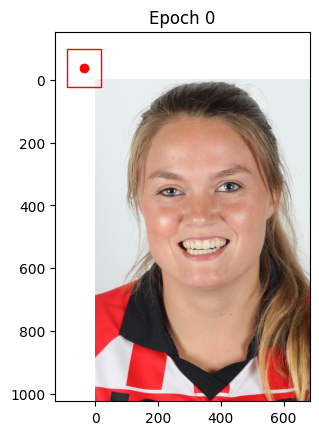

Epoch 10, Loss: 62.6688


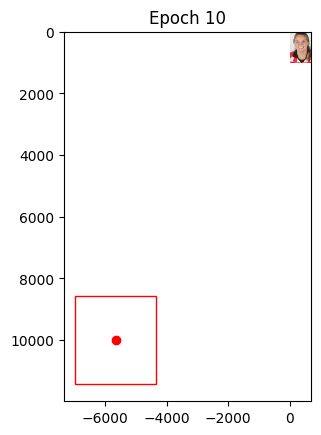

Epoch 20, Loss: 0.3582


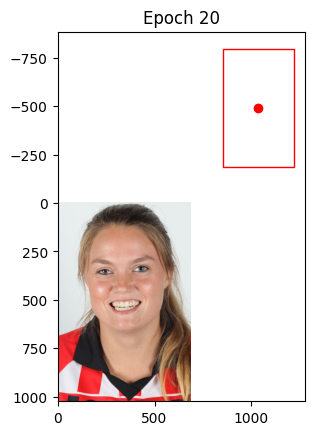

Epoch 30, Loss: 0.0436


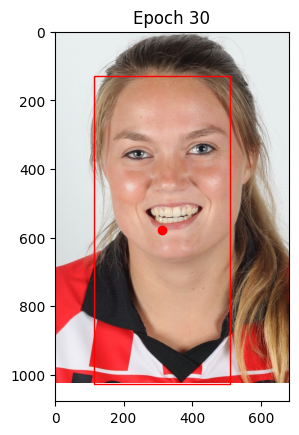

Epoch 40, Loss: 0.0367


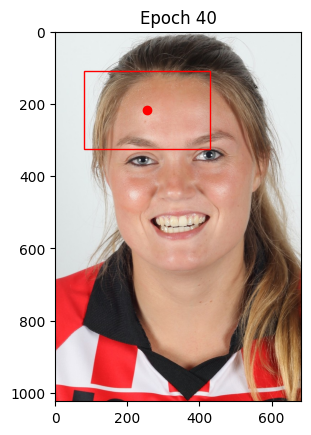

Epoch 50, Loss: 0.0025


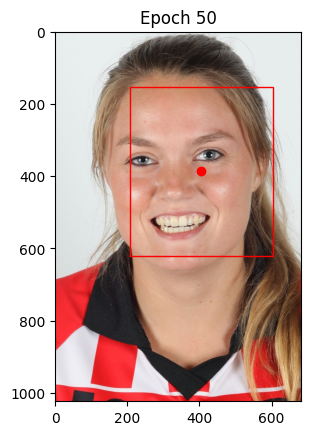

Epoch 60, Loss: 0.0033


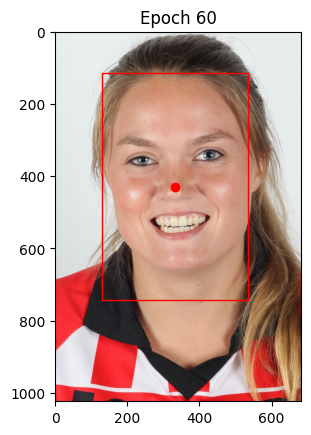

Epoch 70, Loss: 0.0009


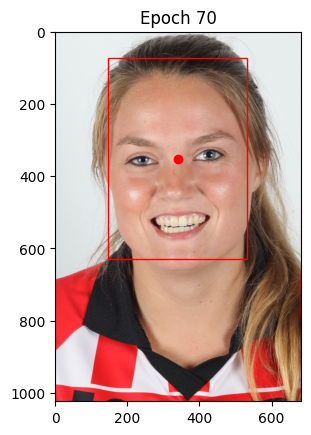

Epoch 80, Loss: 0.0001


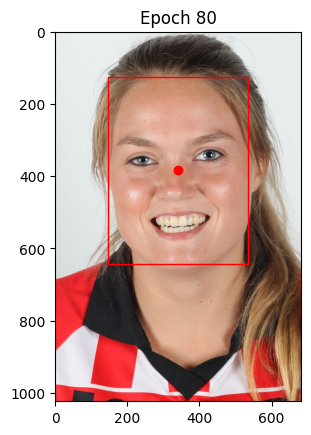

Epoch 90, Loss: 0.0002


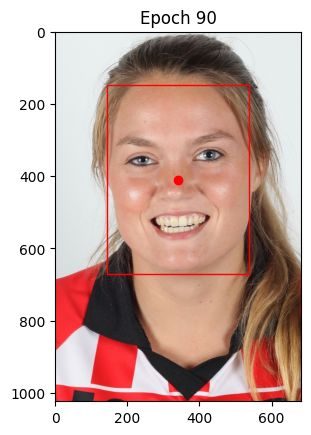

Epoch 100, Loss: 0.0000


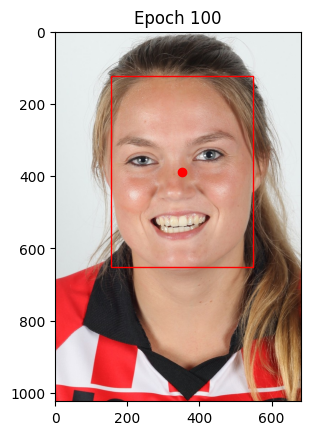

In [43]:

# Training loop
n_epochs = 100
for epoch in range(n_epochs + 1):
    optimizer.zero_grad()
    output = model(img_tensor)
    loss = criterion(output, bbox)
    loss.backward()
    optimizer.step()
    
    # Print progress
    if epoch % 10 == 0 or epoch == n_epochs:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
        visualize_prediction(img_tensor, output.squeeze().detach(), epoch)

In [44]:
def visualize_prediction(img_tensor, bbox_pred, epoch):
    img_np = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    H, W = img_np.shape[:2]
    
    fig, ax = plt.subplots()
    ax.imshow(img_np)
    
    # Convert normalized predictions to pixel coordinates
    x_center = bbox_pred[1].item() * W
    y_center = bbox_pred[2].item() * H
    width = bbox_pred[3].item() * W
    height = bbox_pred[4].item() * H
    
    # Plot center and box
    plt.plot(x_center, y_center, 'ro')
    rect = plt.Rectangle(
        (x_center - width/2, y_center - height/2),
        width, height,
        fill=False,
        color='red'
    )
    ax.add_patch(rect)
    plt.title(f'Epoch {epoch}')
    plt.show()
